In [16]:
library(ggplot2)

In [17]:
col=c("#4197d8", "#f8c120", "#413496", "#495226", "#d60b6f", "#e66519", "#d581b7", "#83d3ad", "#7c162c", "#26755d")

In [18]:
loess_span_select <- function(value, pos){
	# get spans
	#span <- seq(round(50/length(pos),digits=3), 1, 0.001)
	#span <- seq(round(50/length(pos),digits=2), 1, 0.01)
	#span <- seq(round(50/length(pos),digits=2), 1, 0.03)
	span <- seq(round(50/length(pos),digits=2), 1, 0.05)
	#span <- seq(0.01, 1, 0.05)
	#span <- c(0.025)
	span <- matrix(span,,1)
	cat("span", as.vector(span),"\n")
	# iter
	span.aicc <- apply(span, 1, aicc, value=value, pos=pos)
	cat("span.aicc", as.vector(span.aicc),"\n")
	# get min aicc
	span.notna <- span[!is.na(span.aicc)]
	span.aicc.notna <- span.aicc[!is.na(span.aicc)]
	m <- min(span.aicc.notna)
	if( is.infinite(m) ){
		cat("span selecting failed: min is infinite\n")
		q(status=1)
	}
	# return
	return( span.notna[span.aicc.notna==m] )
}
fit_by_loess <- function(x,pos){
	# check the number of points for fitting
	if ( length(x) < 50 ){
		cat("the number of points for fitting is too small(<50)\n")
		q(status=1)
	}
	# get best span
	s <- loess_span_select(x, pos)
	s <- s[1] 	# get one of span
	cat("best_span\t", s, "\n")
	# fitting
	loe <- loess(x ~ pos, span = s, degree=1, family='symmetric', surface='direct')
	# return
	loe$fitted
}
win_by_snpnum <- function(x,width){
	p <- x
	len <- length(x)
	for ( i in 1:len ){
		p[i] <- median(x[max(1,i-width):min(len,i+width)])
	}
	p
}
# for window by DISTANCE
# for window by DISTANCE
win_by_distance <- function(x,pos,width){
	p <- x
	len <- length(x)
	for ( i in 1:len ){
		p[i] <- mean(x[ (pos>pos[i]-width) & (pos<pos[i]+width) ])
	}
	p
}

In [19]:
rawdata<-read.table('./GJvsXI.windowed.weir.fst',header = T,comment.char = "")
rawdata<-rawdata[,c("CHROM", "BIN_START", "BIN_END", "WEIGHTED_FST")]
colnames(rawdata)<-c("chr","start","end","value")
rawdata$value[rawdata$value<0]=0
head(rawdata)

,chr,start,end,value
,<int>,<int>,<int>,<dbl>
1,1,1,2000,0.110702
2,1,1001,3000,0.110469
3,1,2001,4000,0.111977
4,1,3001,5000,0.108133
5,1,4001,6000,0.104580
6,1,5001,7000,0.108408


In [20]:
refl<-read.table('./rice.fai',header = F,comment.char = "")
rawdata=rawdata[rawdata$chr%in% refl$V1,]
chr=rawdata$chr
value=rawdata$value
pos=rawdata$start
chr_names<-refl$V1
win.value=rawdata$value
head(refl)

,V1,V2
,<int>,<int>
1,1,43255618
2,2,35935782
3,3,36413322
4,4,35502333
5,5,29948561
6,6,31247197


In [21]:
for ( name in chr_names ) {
	cat("chr_name = ", name, "\n")
	# sub for one chr
	sub <- chr==name
	sub.value <- value[sub]
	sub.pos <- pos[sub]
	win.value[sub] <- win_by_distance(x=sub.value, pos=sub.pos, width=1000000)
}

chr_name =  1 
chr_name =  2 
chr_name =  3 
chr_name =  4 
chr_name =  5 
chr_name =  6 
chr_name =  7 
chr_name =  8 
chr_name =  9 
chr_name =  10 
chr_name =  11 
chr_name =  12 


In [22]:
rawdata$smooth.value=win.value
chrlen<-refl$V2
names(chrlen)<-refl$V1
blank=0.01*sum(chrlen)
chrpos<-cumsum(chrlen[-length(chrlen)]+blank)
chrpos<-c(0,chrpos)
names(chrpos)<-names(chrlen)
#chrpos<-chrpos-pos[1,names(chrpos)]
chrid<- as.character(rawdata$chr)
ylab="Fst"
quantile(rawdata$value,c(0.01,0.05,0.8,0.90,0.95,0.99),na.rm=T)
threshold=quantile(rawdata$value,1-0.05,na.rm=T)
M=mean(rawdata$value)
S=sd(rawdata$value)
rawdata$value=(rawdata$value-M)/S
ylab=expression(Z(Fst))
threshold=quantile(rawdata$value,1-0.05)

1%         5%        80%        90%        95%        99% 
0.01386503 0.08421478 0.80047900 0.86830920 0.90928160 0.95412232

In [29]:
#plot manhattan
plot.data<- data.frame(chr=as.character(rawdata$chr),pos=rawdata$start+chrpos[chrid],value=rawdata$smooth.value)
plot.data$chr=factor(plot.data$chr, levels = refl$V1,ordered=T)
p<-ggplot(plot.data,aes(x=pos,y=value,colour=chr))
p<-p+geom_line(size=0.5)
p<-p+scale_colour_manual(values=rep(c("#eb65a0", "#22c2e4", "#4abb6b","#f28d21"),times=100))+
		labs(x="Chromosome",y=ylab,title="")
xat<- sapply(tapply(plot.data$pos,plot.data$chr,function(x)mean(range(x))), unlist)
p<-p+scale_x_continuous(expand = c(0.001,0),breaks=xat,labels=names(xat)) 
		#geom_hline(yintercept = threshold,linetype = 2, size = 0.2)   #水平阈值线
p<-p+theme_classic()+theme(axis.text=element_text(size = 14),
		axis.text.x=element_text(angle = 65,vjust=1,hjust=1),  #染色体名称对齐角度
		axis.title=element_text(size = 16), #
		plot.title=element_text(size =24,hjust=0.5),
		legend.position='none')+ scale_y_continuous(expand = c(0,0))

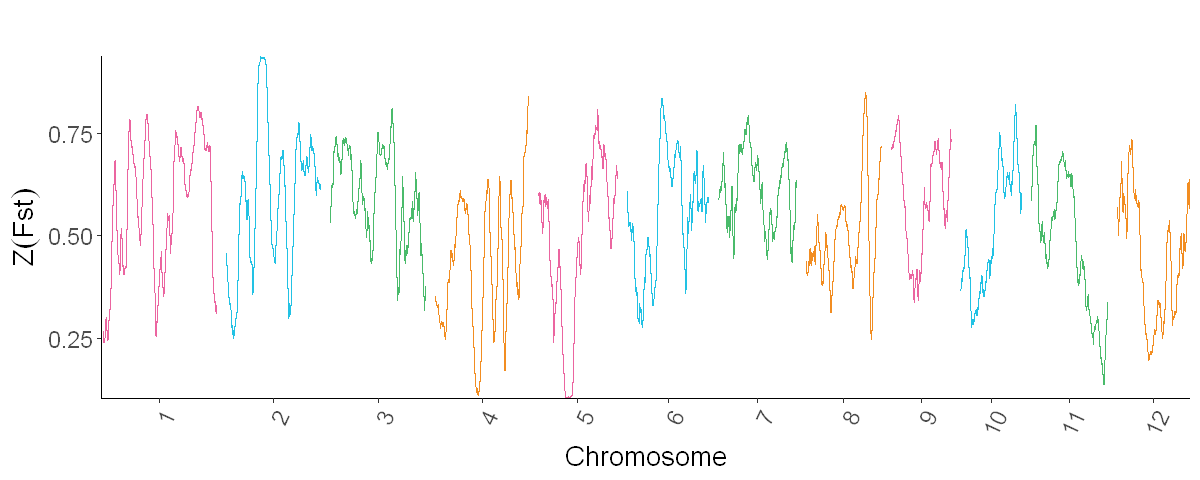

In [30]:
options(repr.plot.width=10, repr.plot.height=4)
p